#Zadanie 2 (7 pkt)
Celem zadania jest rozwiązanie zadania optymalizacji przy pomocy algorytmu genetycznego. Należy znaleźć minimum zadanej funkcji:
\begin{equation}
f(x) = 1.5-\exp \left\{-x_1^2-x_2^2\right\}-0.5 \exp \left\{-\left(x_1-1\right)^2-\left(x_2+2\right)^2\right\}
\end{equation}
Należy wykorzystać mechanizmy krzyżowania punktowego, mutacji oraz selekcji turniejowej. Proszę wykorzystać przygotowany szkielet i zaimplementować niezbędne metody. Opracowane oprogramowanie powinno być uniwersalne - wymiar funkcji, której minimum szukamy może być dowolny (mechanizm *args). Punktacja wygląda następująco:

*   Stworzenie obiektu klasy *Chromosome* z polem *array*, które jest wektorem aktywnych i nieaktywnych genów - **0.5 pkt**
*   Implementacja metody *decode*, która dekoduje część chromosomu (określoną przez początek (*lower_bound*) i koniec (*upper_bound*)) do postaci liczby rzeczywistej. *aoi* to zakres wartości zdekodowanej liczby rzeczywistej. Przykład: liczba 135 w postaci binarnej zapisana przy użyciu 8 bitów to 1000 0111, jeśli nasze *aoi* to [0, 1], to 135 sprowadzone do tego zakresu to 0.529. Można skorzystać z funkcji pomocniczej *min_max_norm* - **1 pkt**
*   Implementacja metody *mutation*, która przyjmuje jako argument prawdopodobieństo mutacji i zmienia wartość jedego, losowego genu na przeciwną - **0.5 pkt**
*   Implementacja metody *crossover*, która wykonuje operację krzyżowania jednopunktowego - **1 pkt**
*   Implementacja metody *eval_objective_func*, która dekoduje cały chromosom (otrzymuje się argumenty funkcji) oraz zwraca wartość funkcji celu dla tych argumentów - **1 pkt**
*   Implementacja metody *tournament_selection*, która przeprowadza selekcję turniejową - **1 pkt**
*   Implementacja metody *reproduce*, która generuje nowe pokolenie - z pewnym prawdopodobieństwem przeprowadza krzyżowanie jednopunktowe lub "przerzuca" rodziców do nowego pokolenia - **0.5 pkt**
*   Implementacja metody *run*, która wykonuje cały alorytm genetyczny dla określonej liczby pokoleń. W każdym pokoleniu należy zapisać dane osobnika z najlepszym chromosomem zdekodowane wartości x i y oraz wartość funkcji strat dla tego osobnika - **0.5 pkt**
*   Proszę, podobnie jak miało to miejsce w przypadku metody gradientowej z poprzednich zajęć, wygenerować wykres przy użyciu funkcji *plot_func* (w przypadku innego typu argumentu *trace*, funkcję można zmodyfikować. Wykres powinien przedstawiać funkcję, której minimum poszukujemy oraz punkty odpowiadające najlepszym osobnikom w danych generacjach, których kolor jest coraz jaśniejszy wraz ze zbliżaniem się do minimum. Proszę zapisać swoje wnioski, w szczególności w odniesieniu do metody gradientowej. - **1 pkt**


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
import logging
import logging

logger = logging.getLogger()
logger.setLevel(logging.WARNING)



In [3]:
def min_max_norm(val, min_val, max_val, new_min, new_max):
  return (val - min_val) * (new_max - new_min) / (max_val - min_val) + new_min
    
def binary_to_decimal(binary):
  return sum(val*(2**idx) for idx, val in enumerate(reversed(binary)))

In [4]:
class Chromosome:
  def __init__(self, length, array=None): #if array is None it should be initialized with random binary vector
    self.genes_array = array if array is not None else np.random.randint(0,2, length);
    self.length = length

  def decode(self, lower_bound, upper_bound, aoi):   
    array = self.genes_array[lower_bound : upper_bound] 
    value = binary_to_decimal(array)
    arg_len = upper_bound - lower_bound
    max_value = binary_to_decimal(np.full(arg_len, 1))
    return min_max_norm(value, 0, max_value, aoi[0], aoi[1])

    

  def mutation(self, probability):
    for i in range(self.length):
      if random.random() < probability:
        self.genes_array[i] = (self.genes_array[i] + 1 )% 2 

    
  def crossover(self, other):
    cross_point = random.randint(1, self.length - 2)
    self_x = self.genes_array[:cross_point]
    other_x = other.genes_array[:cross_point]
    
    self_y = self.genes_array[cross_point:]
    other_y = other.genes_array[cross_point:]
    
    cross_child_genes_1 = np.concatenate((self_x, other_y))
    cross_child_genes_2 = np.concatenate((other_x, self_y))
    
    child_1 = Chromosome(self.length, cross_child_genes_1)
    child_2 = Chromosome(self.length, cross_child_genes_2)
    return child_1, child_2


In [5]:
class GeneticAlgorithm:
    def __init__(self, chromosome_length, obj_func_num_args, objective_function, aoi, population_size=1000,
                tournament_size=2, mutation_probability=0.05, crossover_probability=0.8, num_steps=30):
        assert chromosome_length % obj_func_num_args == 0, "Number of bits for each argument should be equal"
        self.chromosome_length= chromosome_length
        self.obj_func_num_args = obj_func_num_args
        self.bits_per_arg = int(chromosome_length / obj_func_num_args)
        self.objective_function = objective_function
        self.aoi = aoi
        self.population_size = population_size
        self.tournament_size = tournament_size
        self.mutation_probability = mutation_probability
        self.crossover_probability = crossover_probability
        self.num_steps = num_steps
        self.current_population = np.array(
            [Chromosome(length=self.chromosome_length)
            for _ in range(self.population_size)])

    def eval_objective_func(self, chromosome):
        args_vals = self.decode_chromosome(chromosome)
        return self.objective_function(args_vals)

    def decode_chromosome(self, chromosome):
        indeces = range(self.chromosome_length + 1)
        bounds = list(indeces[ : : self.bits_per_arg])   
        return [chromosome.decode(bound, bounds[i+1], self.aoi[i]) for i, bound in enumerate(bounds[:-1])]


    def tournament_selection(self):
        logging.info("--- Start Tournament ---")
            
        new_population = []
        for _ in range(self.population_size):
            tournament_participants = np.random.choice(self.current_population, self.tournament_size)
            best_chromosome = min(tournament_participants , key=lambda chromosome : self.eval_objective_func(chromosome))
            new_population.append(best_chromosome)
            logging.debug("Winner: " + str(best_chromosome.genes_array))
            
        logging.info("--- End Tournament ---")
        return np.array(new_population)
            

    def reproduce(self):
        logging.info("--- Begin Reproduce ---")
        new_population = []
        parent_pairs = itertools.combinations(self.current_population, 2)
        
        for pair in parent_pairs:
            parent_1, parent_2 = pair
            
            if random.random() < self.crossover_probability:
                child_1, child_2 = parent_1.crossover(parent_2)
                new_population.append(child_1)
                new_population.append(child_2)
            else:  
                new_population.append(parent_1)
                new_population.append(parent_2)
                
        logging.info("---- End Reproduce ----")
        return np.array(new_population)


    def plot_func(self, trace):
        X = np.arange(-2, 3, 0.05)
        Y = np.arange(-4, 2, 0.05)
        X, Y = np.meshgrid(X, Y)
        Z = 1.5 - np.exp(-X ** (2) - Y ** (2)) - 0.5 * np.exp(-(X - 1) ** (2) - (Y + 2) ** (2))
        plt.figure()
        plt.contour(X, Y, Z, 10)
        cmaps = [[ii / len(trace), 0, 0] for ii in range(len(trace))]
        plt.scatter([x[0] for x in trace], [x[1] for x in trace], c=cmaps)
        plt.show()


    def mutate(self):
        logging.info("----Begin mutation----")
        for chromosome in self.current_population:
            chromosome.mutation(self.mutation_probability)
        logging.info("----End mutation----")



    def run(self):
        
        trace = []
        fitness_array = []
        for i in range(self.num_steps):
            logging.info(f'STEP {i}')
            self.current_population = self.tournament_selection()
            self.current_population = self.reproduce()
            self.mutate()

            best_chromosome = min(
                self.current_population, key=lambda chromosome: self.eval_objective_func(chromosome))
            args = np.array(self.decode_chromosome(best_chromosome))
            fitness = self.eval_objective_func(best_chromosome)
            fitness_array.append(fitness)
            trace.append(np.array(args))

            if self.population_size >= 100 or i % 5 == 0: 
                print(
                    f'STEP {i} fitness val: {fitness:.5f},  args: [{args[0]:.5f}, {args[1]:.5f}]')
            
            if len(fitness_array) > 2 and abs(fitness_array[-1] - fitness_array[-2]) < 0.00001:
                print(f"Ending algorithm at step {i} ")
                break

        print(f"Result: fitness value = {fitness:.5f}, args = [{trace[-1][0]:.5f}, {trace[-1][0]:.5f}]")
        trace = np.array(trace)
        self.plot_func(trace)



def my_function(args):
    x1 = args[0]
    x2 = args[1]
    return  1.5 - np.exp(-x1** (2) - x2 ** (2)) - 0.5 * np.exp(-(x1 - 1) ** (2) - (x2 + 2) ** (2))

### Population size impact

* Number of steps       - 30
* mutation probability  - 0.05 
* crossover probability - 0.8

Plots for population sizes: 10, 100, 500 and 300

POPULATION SIZE: 10, STEPS NUMBER: 30
STEP 0 fitness val: 0.50587,  args: [-0.06940, -0.07038]
STEP 5 fitness val: 0.56451,  args: [-0.08407, 0.24633]
Ending algorithm at step 9 
Result: fitness value = 0.51823, args = [-0.02053, -0.02053]


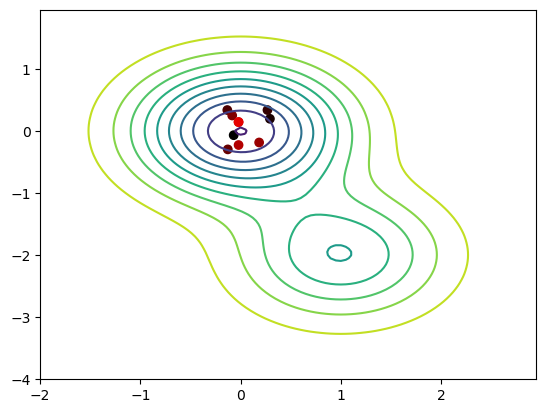

POPULATION SIZE: 100, STEPS NUMBER: 30
STEP 0 fitness val: 0.50006,  args: [0.06256, -0.01173]
STEP 1 fitness val: 0.49791,  args: [-0.02542, -0.02933]
STEP 2 fitness val: 0.49670,  args: [-0.00098, -0.01760]
STEP 3 fitness val: 0.49659,  args: [-0.00098, -0.00587]
STEP 4 fitness val: 0.49659,  args: [-0.00098, -0.00587]
Ending algorithm at step 4 
Result: fitness value = 0.49659, args = [-0.00098, -0.00098]


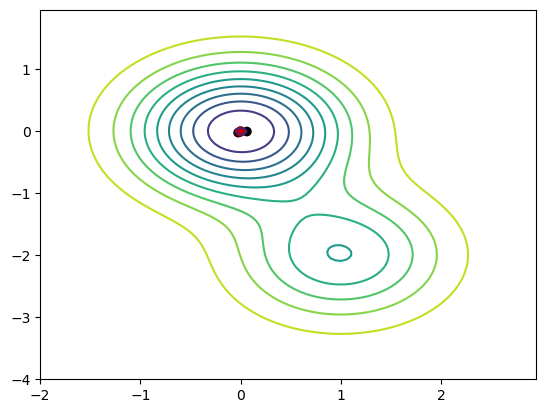

POPULATION SIZE: 500, STEPS NUMBER: 30
STEP 0 fitness val: 0.49659,  args: [0.00391, -0.01173]
STEP 1 fitness val: 0.49657,  args: [0.00391, -0.00587]
STEP 2 fitness val: 0.49662,  args: [-0.00098, -0.01173]
STEP 3 fitness val: 0.49659,  args: [0.00391, -0.01173]
STEP 4 fitness val: 0.49657,  args: [0.00391, -0.00587]
STEP 5 fitness val: 0.49657,  args: [0.00391, -0.00587]
Ending algorithm at step 5 
Result: fitness value = 0.49657, args = [0.00391, 0.00391]


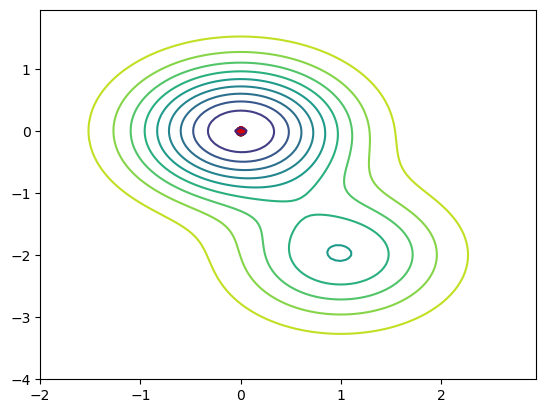

POPULATION SIZE: 1000, STEPS NUMBER: 30
STEP 0 fitness val: 0.49662,  args: [-0.00098, -0.01173]
STEP 1 fitness val: 0.49657,  args: [0.00391, -0.00587]
STEP 2 fitness val: 0.49659,  args: [-0.00098, -0.00587]
STEP 3 fitness val: 0.49657,  args: [0.00391, -0.00587]
STEP 4 fitness val: 0.49657,  args: [0.00391, -0.00587]
Ending algorithm at step 4 
Result: fitness value = 0.49657, args = [0.00391, 0.00391]


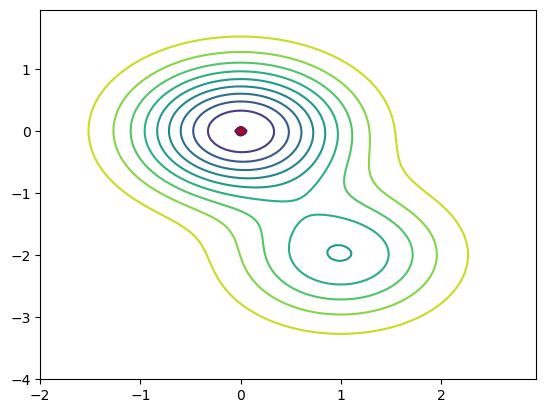

In [6]:


population_size_list = [10, 100, 500, 1000]
steps_num_list = [30]

for p_size in population_size_list:
    for steps_num in steps_num_list:
        print(f'POPULATION SIZE: {p_size}, STEPS NUMBER: {steps_num}')
        gen_algo = GeneticAlgorithm(chromosome_length =20, 
                                    obj_func_num_args =2 , 
                                    objective_function = my_function, 
                                    aoi=[[-2,3], [-4, 2]], 
                                    population_size=p_size, 
                                    tournament_size=2, 
                                    mutation_probability=0.05, 
                                    crossover_probability=0.8, 
                                    num_steps=steps_num)

        gen_algo.run()

### Mutation probability impact

* population size       - 50
* Number of steps       - 30
* crossover probability - 0.8

Plots for mutation probability values: 0.0005, 0.05 and 0.7

POPULATION SIZE: 100, STEPS NUMBER: 30, MUTATION PROBABILITY: 9.0
STEP 0 fitness val: 0.50336,  args: [-0.07918, -0.00587]
STEP 5 fitness val: 0.50009,  args: [-0.05474, 0.00587]
Ending algorithm at step 9 
Result: fitness value = 0.49997, args = [-0.05474, -0.05474]


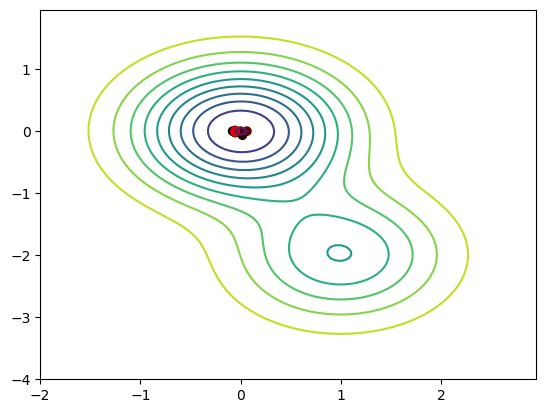

POPULATION SIZE: 100, STEPS NUMBER: 30, MUTATION PROBABILITY: 5e-08
STEP 0 fitness val: 0.50215,  args: [-0.06940, -0.02346]
STEP 5 fitness val: 0.49775,  args: [-0.03030, 0.00000]
Ending algorithm at step 8 
Result: fitness value = 0.53227, args = [0.19453, 0.19453]


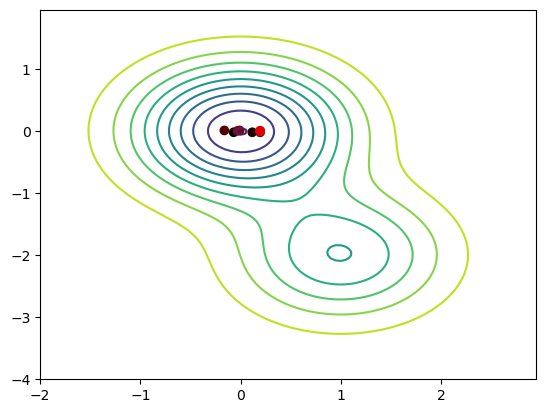

POPULATION SIZE: 100, STEPS NUMBER: 30, MUTATION PROBABILITY: 0.05
STEP 0 fitness val: 0.49767,  args: [-0.01075, 0.02346]
STEP 5 fitness val: 0.49922,  args: [0.04301, -0.04106]
STEP 10 fitness val: 0.49677,  args: [-0.01075, -0.00587]
Ending algorithm at step 13 
Result: fitness value = 0.49694, args = [0.01369, 0.01369]


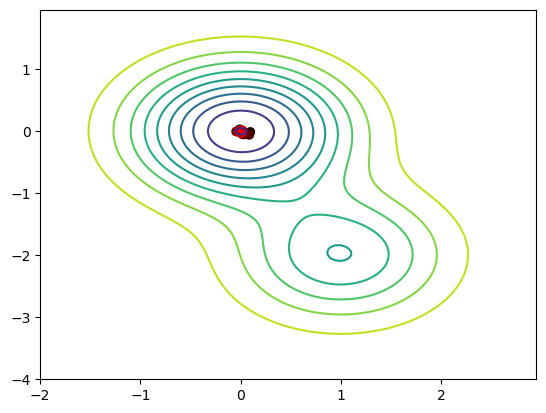

POPULATION SIZE: 100, STEPS NUMBER: 30, MUTATION PROBABILITY: 0.7
STEP 0 fitness val: 0.49685,  args: [0.01857, 0.00000]
STEP 5 fitness val: 0.49962,  args: [0.04790, -0.04106]
STEP 10 fitness val: 0.50727,  args: [0.09189, 0.04692]
STEP 15 fitness val: 0.50143,  args: [0.02835, 0.05865]
STEP 20 fitness val: 0.50373,  args: [0.03324, -0.08798]
STEP 25 fitness val: 0.51631,  args: [-0.12805, 0.04692]
Result: fitness value = 0.50964, args = [-0.00098, -0.00098]


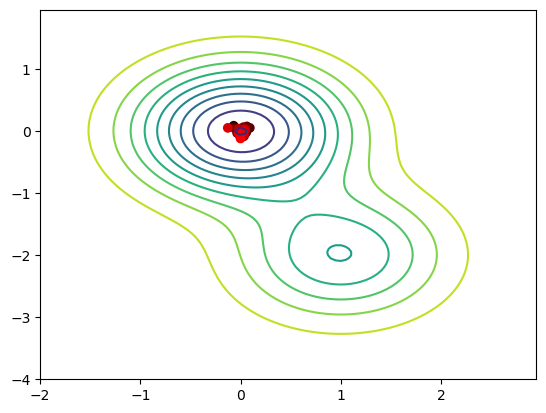

In [8]:
mutation_probability_array = [0.9, 0.00000005, 0.05, 0.7]


for mutation_probability in mutation_probability_array:
        print(f'POPULATION SIZE: 100, STEPS NUMBER: 30, MUTATION PROBABILITY: {mutation_probability}')
        gen_algo = GeneticAlgorithm(chromosome_length=20,
                                    obj_func_num_args=2,
                                    objective_function=my_function,
                                    aoi=[[-2, 3], [-4, 2]],
                                    population_size=50,
                                    tournament_size=2,
                                    mutation_probability=mutation_probability,
                                    crossover_probability=0.8,
                                    num_steps=30)

        gen_algo.run()

### Crossover probability impact

* population size       - 50
* Number of steps       - 30
* Mutation probability - 0.05

Plots for crossover probability values: 0.2, 0.8 and 0.9

POPULATION SIZE: 50, STEPS NUMBER: 30, CROSSOVER PROBABILITY: 0.0
STEP 0 fitness val: 0.98664,  args: [0.04790, 0.81525]
STEP 5 fitness val: 0.81657,  args: [-0.09384, 0.60997]
STEP 10 fitness val: 1.45183,  args: [-1.35484, -1.10264]
STEP 15 fitness val: 1.09894,  args: [1.47507, -2.00000]
STEP 20 fitness val: 0.56222,  args: [0.20919, 0.15249]
STEP 25 fitness val: 0.69897,  args: [-0.31378, 0.35191]
Result: fitness value = 0.67228, args = [-0.43597, -0.43597]


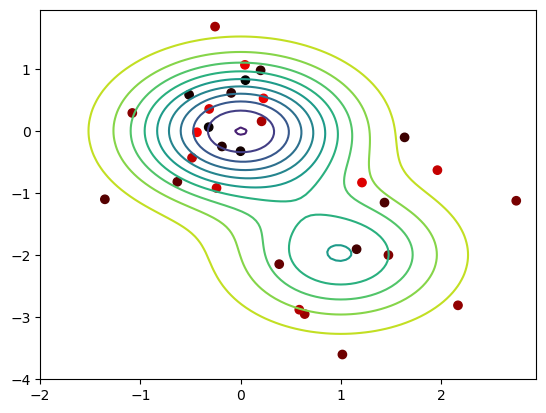

POPULATION SIZE: 50, STEPS NUMBER: 30, CROSSOVER PROBABILITY: 0.2
STEP 0 fitness val: 0.50635,  args: [0.04790, 0.08211]
STEP 5 fitness val: 0.52993,  args: [0.12121, 0.13490]
STEP 10 fitness val: 0.53089,  args: [0.09189, 0.15836]
STEP 15 fitness val: 0.55109,  args: [0.23363, -0.07038]
STEP 20 fitness val: 0.50418,  args: [-0.08407, -0.00587]
STEP 25 fitness val: 0.61609,  args: [0.36070, -0.03519]
Result: fitness value = 0.49773, args = [-0.00098, -0.00098]


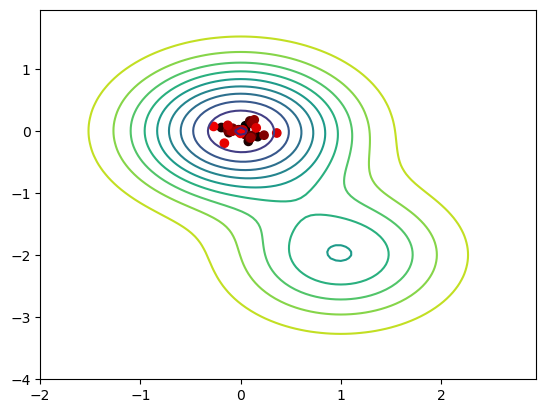

POPULATION SIZE: 50, STEPS NUMBER: 30, CROSSOVER PROBABILITY: 0.8
STEP 0 fitness val: 0.52308,  args: [0.14076, 0.08211]
Ending algorithm at step 4 
Result: fitness value = 0.49659, args = [-0.00098, -0.00098]


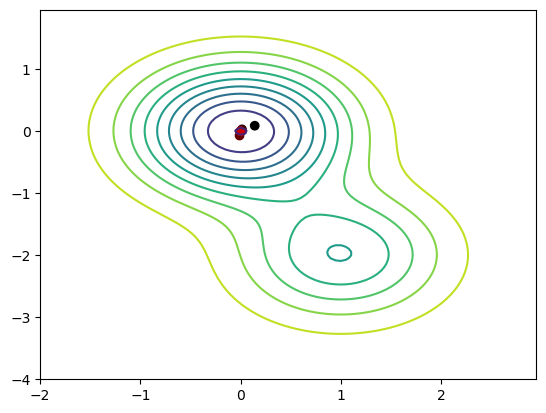

POPULATION SIZE: 50, STEPS NUMBER: 30, CROSSOVER PROBABILITY: 0.99
STEP 0 fitness val: 0.50082,  args: [0.06745, 0.00587]
Ending algorithm at step 3 
Result: fitness value = 0.49675, args = [-0.00098, -0.00098]


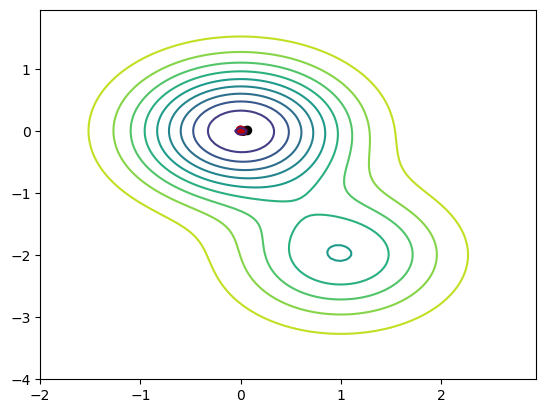

In [9]:
crossover_probability_array = [0.0, 0.2, 0.8, 0.99]


for crossover_probability in crossover_probability_array:
    print(f'POPULATION SIZE: 50, STEPS NUMBER: 30, CROSSOVER PROBABILITY: {crossover_probability}')
    gen_algo = GeneticAlgorithm(chromosome_length=20,
                                obj_func_num_args=2,
                                objective_function=my_function,
                                aoi=[[-2, 3], [-4, 2]],
                                population_size=50,
                                tournament_size=2,
                                mutation_probability=0.05,
                                crossover_probability=crossover_probability,
                                num_steps=30)

    gen_algo.run()

POPULATION SIZE: 100, STEPS NUMBER: 30, CHROMOSOME LENGTH: 4
STEP 0 fitness val: 0.60361,  args: [-0.33333, 0.00000]
Ending algorithm at step 2 
Result: fitness value = 0.60361, args = [-0.33333, -0.33333]


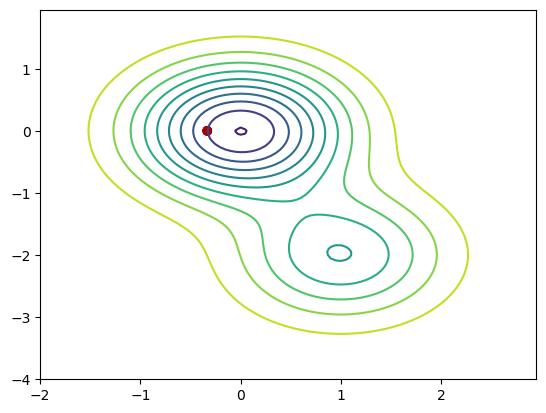

POPULATION SIZE: 100, STEPS NUMBER: 30, CHROMOSOME LENGTH: 8
STEP 0 fitness val: 0.49663,  args: [0.00000, 0.00000]
Ending algorithm at step 2 
Result: fitness value = 0.49663, args = [0.00000, 0.00000]


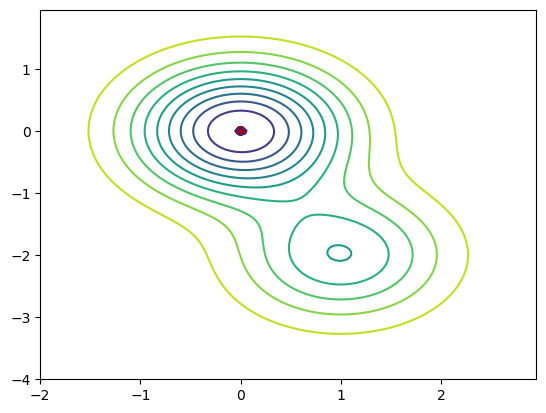

POPULATION SIZE: 100, STEPS NUMBER: 30, CHROMOSOME LENGTH: 10
STEP 0 fitness val: 0.50602,  args: [-0.06452, 0.06452]
Ending algorithm at step 2 
Result: fitness value = 0.50602, args = [-0.06452, -0.06452]


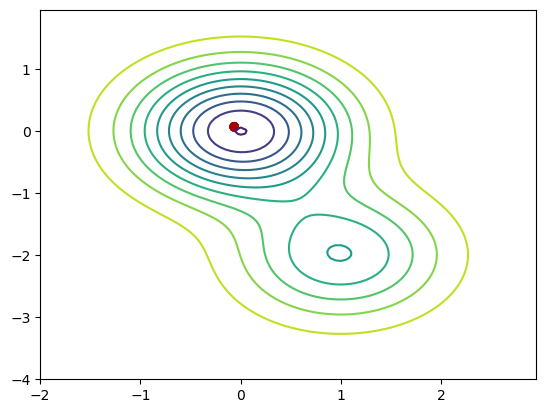

POPULATION SIZE: 100, STEPS NUMBER: 30, CHROMOSOME LENGTH: 20
STEP 0 fitness val: 0.49763,  args: [0.03324, 0.00587]
STEP 5 fitness val: 0.49662,  args: [-0.00098, -0.01173]
STEP 10 fitness val: 0.49666,  args: [-0.00587, -0.00587]
STEP 15 fitness val: 0.49700,  args: [-0.00587, 0.01173]
STEP 20 fitness val: 0.49811,  args: [0.02835, 0.02346]
STEP 25 fitness val: 0.49745,  args: [-0.02542, 0.00000]
Result: fitness value = 0.49664, args = [-0.00098, -0.00098]


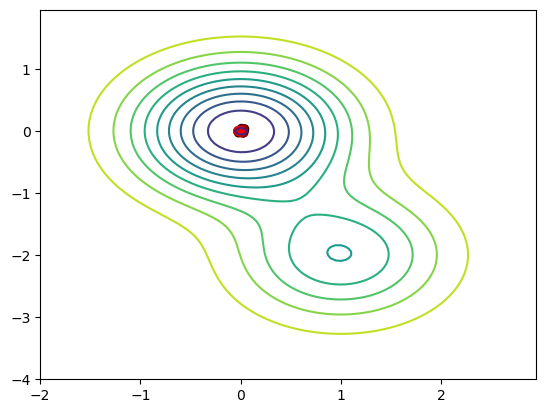

In [14]:
chromosome_len_array = [4, 8, 10, 20]

for chromosome_length in chromosome_len_array:
        print(f'POPULATION SIZE: 100, STEPS NUMBER: 30, CHROMOSOME LENGTH: {chromosome_length}')
        gen_algo = GeneticAlgorithm(chromosome_length=chromosome_length,
                                    obj_func_num_args=2,
                                    objective_function=my_function,
                                    aoi=[[-2, 3], [-4, 2]],
                                    population_size=50,
                                    tournament_size=2,
                                    mutation_probability=0.05,
                                    crossover_probability=0.8,
                                    num_steps=30)

        gen_algo.run()

# Wnioski 

Mnogość kombinacji różnych parametrów algorytmu utrydniają jego kalibrację.

Zwiększanie podobieństwa mutacji pozwala przeszukać większy obszar przestrzeni, dzięki czemu umożliwia przeskoczenie optimum lokalnego. Zbyt małe prawdopodobieństwo mutacji, może spowodować, że algorytm potrzebuje więcej iteracji do odnalezienia optimum. 

Zbyt małe prawdopodobieństwo krzyżowania powoduje wolniejsze zbieganie rozwiązania algorytmu. 

W porównaniu do metody gradientowej, ścieżka rozwiązań znalezionych przez algorytm ewolucyjny nie jest ograniczona przez dziedzinę funkcji. Algorytm może np. przeskoczyć punkty nieciągłości.Jest także mniej podatny na odnajdywanie minimum lokalnych.  

Algorytm genetyczny jest jednak dużo trudniejszy do kalibracji. 

